In [39]:
from pledge.network import *
from pledge.consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

step_size_epochs = 120  # 60 minutes
simulation_epochs = 10 * YEAR
stats_interval_epochs = DAY
netcfg = dataclasses.replace(
    MAINNET_APR_2023,
    # The baseline function effectively works as a divisor of the initial pledge,
    # so is excluded here to make results more clear.
    baseline_growth=0.0,
)

# Onboarding rate required to replace sectors that reach end of life,
# assuming all sectors are extended to their maximum lifetime.
replacement_onboarding = netcfg.qa_power / SECTOR_LIFETIME_DEFAULT * DAY


def run(b: BehaviourConfig):
    net = NetworkState(netcfg, b, epoch_step=step_size_epochs)
    first_step = net.step_no
    stats = []
    for step in range(first_step, first_step + simulation_epochs // step_size_epochs):
        if step % (stats_interval_epochs // step_size_epochs) == 0:
            stats.append(net.summary())
        net.handle_epochs()
    return stats

In [40]:
def display_one(df: pd.DataFrame):
    plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.3)

    plt.subplot(grid[0, 0])
    plt.plot(df['day'], df['power'] / float(EXBIBYTE), label='Power')
    plt.xlabel('Day')
    plt.ylabel('EiB')
    plt.ylim(0)
    plt.legend()

    plt.subplot(grid[0, 1])
    plt.plot(df['day'], df['circulating_supply'] / 1e6, label='Circulating Supply')
    plt.plot(df['day'], df['pledge_locked'] / 1e6, label='Pledge Locked')
    plt.plot(df['day'], df['reward_locked'] / 1e6, label='Reward Locked')
    plt.xlabel('Day')
    plt.ylabel('MFIL')
    plt.title('Network Tokens')
    plt.legend()

    plt.subplot(grid[1, 0])
    plot_sector_pledge(plt, {'Sector pledge': df})

    plt.subplot(grid[1, 1])
    plot_pledge_ratio(plt, {'Pledge ratio': df})

def display_comparison(dfs: dict[str, pd.DataFrame]):
    plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.3)
    plt.subplot(grid[1, 0])
    plot_sector_pledge(plt, dfs)

    plt.subplot(grid[1, 1])
    plot_pledge_ratio(plt, dfs)

def plot_sector_pledge(plt, dfs: dict[str, pd.DataFrame]):
    for label, df in dfs.items():
        plt.plot(df['day'], df['sector_pledge'], label=label)
    plt.xlabel('Day')
    plt.ylim(0)
    plt.ylabel('FIL')
    plt.title('32GiB Initial Pledge')
    plt.legend()


def plot_pledge_ratio(plt, dfs: dict[str, pd.DataFrame]):
    for label, df in dfs.items():
        plt.plot(df['day'], df['locked_target'] * 100, label=label)
    plt.axhline(y=30, color='k', linestyle='--')
    plt.xlabel('Day')
    plt.ylim(0, 40)
    plt.ylabel('%')
    plt.title('Pledge / Circulating Supply')
    plt.legend()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


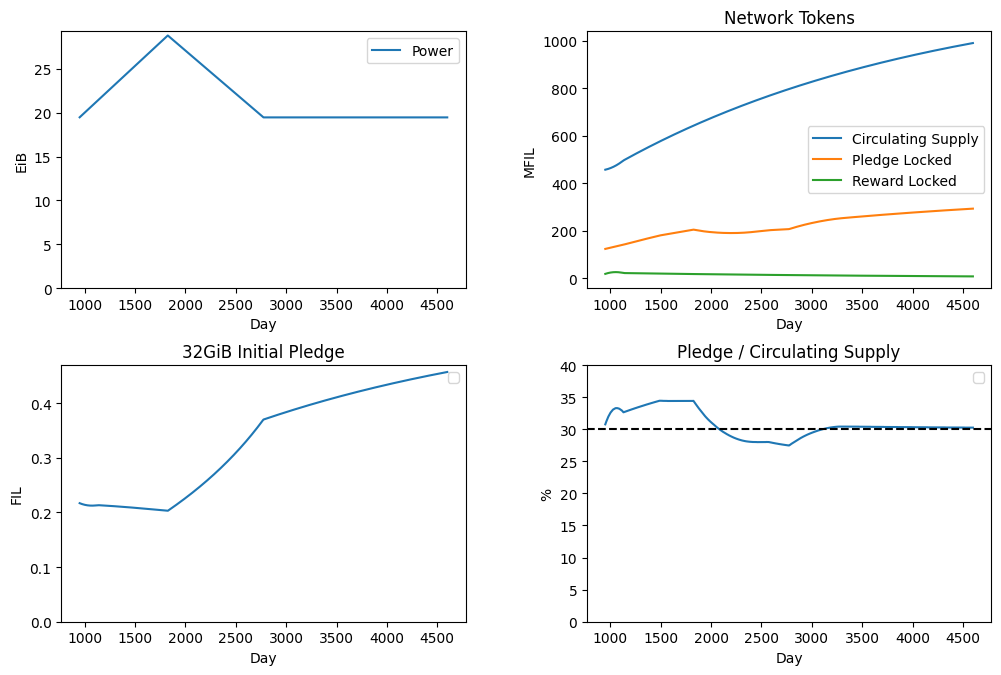

In [41]:
# With onboarding at replacement rate, the lock target is met exactly (after initial conditions shake out)
stats = pd.DataFrame(run(BehaviourConfig(
    sector_commitment_epochs=SECTOR_COMMITMENT_DEFAULT,
    extension_rate=1.0,
    onboarding_daily=replacement_onboarding,
)))
display_one(stats)


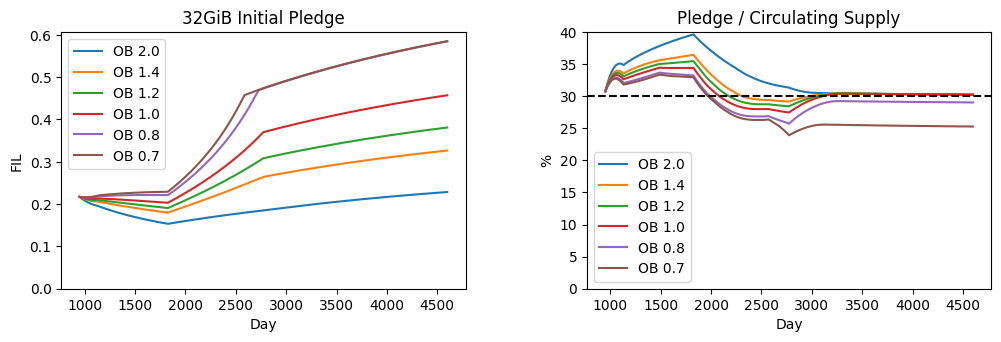

In [51]:
# Compare different onboarding rates.
# When onboarding is at long-run replacement, or within about 20% below it, the lock target is met.
# When too low, the target is missed.
stass = {
    "OB %.1f" % (f,):
        pd.DataFrame(run(BehaviourConfig(
            sector_commitment_epochs=SECTOR_COMMITMENT_DEFAULT,
            extension_rate=1.0,
            onboarding_daily=f * replacement_onboarding,
        ))) for f in (1.4, 1.2, 1.0, 0.8, 0.75, 0.7, 0.65)}

display_comparison(stass)


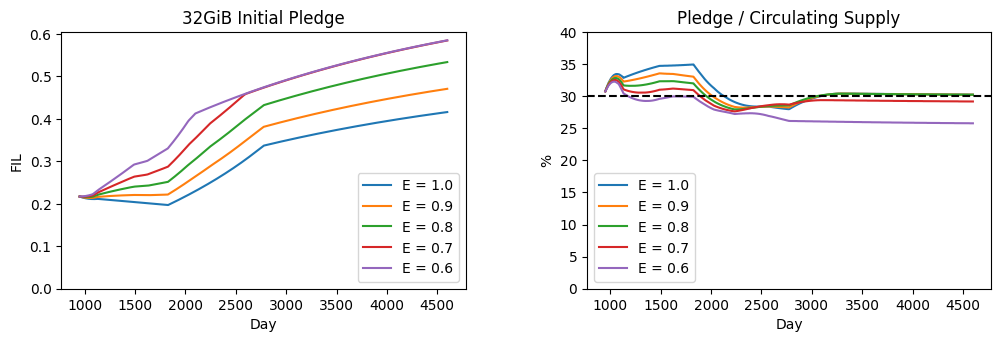

In [49]:
# Compare different extension rates.
# Lower extension rates, for fixed onboarding, settle at a different target.
# Effectively, the fixed replacement rate is too low as average durations decrease.
stass = {
    "E = %.1f" % (e,):
        pd.DataFrame(run(BehaviourConfig(
            sector_commitment_epochs=SECTOR_COMMITMENT_DEFAULT,
            extension_rate=e,
            onboarding_daily=12 * PEBIBYTE,
        ))) for e in (1.0, 0.9, 0.8, 0.7, 0.6)}

display_comparison(stass)


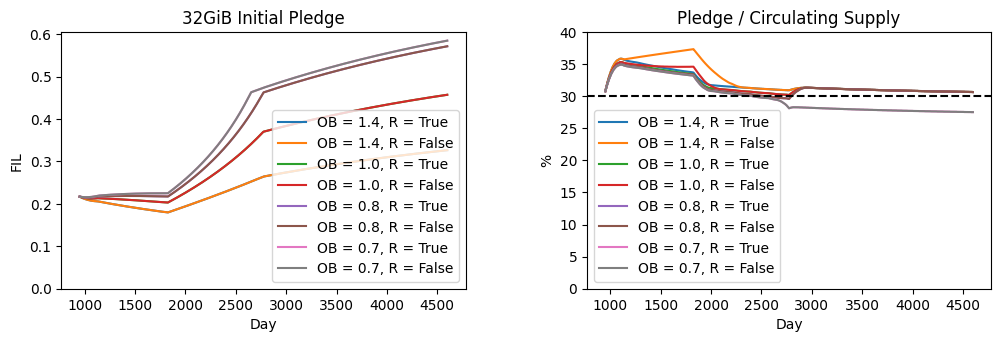

In [52]:
# Rebasing pledge downward when sectors are extended doesn't make any appreciable difference.
stass = {
    "OB = %.1f, R = %s" % (f,r):
        pd.DataFrame(run(BehaviourConfig(
            sector_commitment_epochs=SECTOR_COMMITMENT_DEFAULT / 3, # Short commitments to maximise rebase opportunities
            extension_rate=1.0,
            onboarding_daily=f * replacement_onboarding,
            rebase_pledge=r
        ))) for f in (1.4, 1.0, 0.8, 0.7) for r in (True, False)}

display_comparison(stass)

In [ ]:
# TODO
# - Model exponential onboarding (the lock stays above target)